# Age at the Bottom of the Ocean

This notebook shows a simple example of plotting ocean Ideal Age. Ideal Age is a fictitious tracer which is set to zero in the surface grid-cell every timestep, and is aged by 1 year per year otherwise. It is a useful proxy for nutrients, such as carbon or oxygen (but not an exact analogue). 

One of the interesting aspects of age is that we can use it to show pathways of the densest water in the ocean by plotting a map of age in the lowest gridcell. This plot requires a couple of tricks to extract information from the lowest cell.

**Requirements:** COSIMA Cookbook, preferably installed via the `analysis3-20.04` conda installation on NCI.

Firstly, get all the standard preliminaries out of the way.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cartopy.crs as ccrs
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:37925 Dashboard: /proxy/34761/status,Cluster Workers: 4 Cores: 48 Memory: 202.49 GB


Add a database session - choose one appropriate for the experiment you would like to interrogate.

In [3]:
session = cc.database.create_session('/g/data/ik11/databases/ryf9091.db')

Now, let's set the experiment and time interval, and average ideal age over a year.

In [4]:
expt='01deg_jra55v13_ryf9091'
variable = 'age_global'
start_time='2099-01-01'
end_time = '2099-12-31'
age = cc.querying.getvar(expt,variable,session,ncfile='ocean.nc',start_time=start_time, end_time=end_time, chunks={'st_ocean':None}).sel(time=slice(start_time,end_time)).mean('time')

Here we grab the `kmt` variable out of `ocean_grid.nc`. Note that this is a static variable, so we just look for the last file. This variable tells us the lowest cell which is active at each (x,y) location.

In [5]:
variable='kmt'
kmt = cc.querying.getvar(expt,variable,session,ncfile='ocean_grid.nc', n=-1).fillna(1.0).astype(int) - 1
kmt.load()

<xarray.DataArray 'kmt' (yt_ocean: 2700, xt_ocean: 3600)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolon_t  (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan nan
    geolat_t  (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan nan

Provided that `kmt` is loaded, `xarray` is smart enough to figure out what this line means, and extracts a 2-D field of bottom age for us.

In [6]:
bottom_age = age[kmt]

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


Load some stuff to help with plotting

In [7]:
import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cft.COLORS['land'])

In [8]:
geolon_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_01.nc').geolon_t
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_01.nc').geolat_t

And here is the plot:

Text(0, 0.5, 'Age (yrs)')

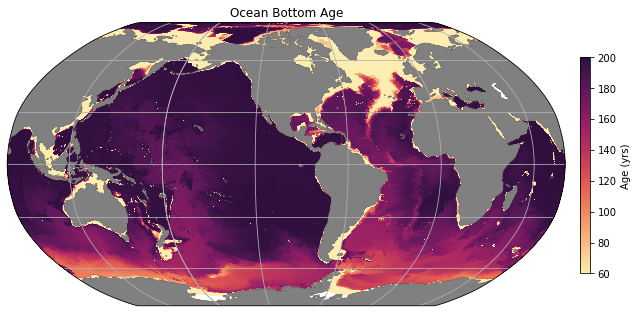

In [9]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m,color='gray')
gl = ax.gridlines(draw_labels=False)
p1 = ax.pcolormesh(geolon_t, geolat_t, bottom_age, transform=ccrs.PlateCarree(),
                   cmap=cm.cm.matter, vmin=60, vmax=200)
plt.title('Ocean Bottom Age')

ax_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical')
cb.ax.set_ylabel('Age (yrs)')

A few things to note here:
* The continental shelves are all young - this is just because they are shallow.
* The North Atlantic is also relatively young, due to formation of NADW. Note that both the Deep Western Boundary Currents and the Mid-Atlantic Ridge both sustain southward transport of this young water.
* A signal following AABW pathways (northwards at the western boundaries) shows slightly younger water in these regions, but it has mixed somewhat with older water above.
* Even after 200 years, the water in the NE Pacific has not experienced any ventilation...